# Pull My Youtube Stats

In [1]:
import os
import re

import google.oauth2.credentials
import google_auth_oauthlib.flow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import seaborn as sns

mypal = sns.color_palette()

import plotly.express as px

import numpy as np

In [2]:
%load_ext lab_black

In [3]:
import datetime

now = datetime.datetime.now()

print("Current date and time: ")
print(now.strftime("%H:%M:%S on %A, %B the %dth, %Y"))

Current date and time: 
21:50:13 on Sunday, July the 10th, 2022


## Create The Service

In [4]:
SCOPES = ["https://www.googleapis.com/auth/yt-analytics.readonly"]

API_SERVICE_NAME = "youtubeAnalytics"
API_VERSION = "v2"
CLIENT_SECRETS_FILE = "YOUR_CLIENT_SECRET_FILE.json"
CLIENT_SECRETS_FILE = "client_secret_427323414311-3hsje8dbb8bsuu97c89k6c2jncgjvlae.apps.googleusercontent.com.json"


def get_service():
    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
    credentials = flow.run_console()
    return build(API_SERVICE_NAME, API_VERSION, credentials=credentials)

In [5]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

youtubeAnalytics = get_service()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=427323414311-3hsje8dbb8bsuu97c89k6c2jncgjvlae.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyt-analytics.readonly&state=GXDZHF91KFI63Nt03UQQjxcH82rhk0&prompt=consent&access_type=offline


Enter the authorization code:  4/1AdQt8qgp9XkI5gdU8TN_9jvQPRLlIzVhh1WeWDLkUK2h27Xx1lJkquc8_Fg


# My Channel Level Data

In [6]:
metrics = (
    """annotationClickThroughRate,annotationCloseRate,averageViewDuration,"""
    """comments,dislikes,estimatedMinutesWatched,likes,shares,subscribersGained,"""
    """subscribersLost,views"""
)

out = (
    youtubeAnalytics.reports()
    .query(
        ids="channel==MINE",
        startDate="2022-01-01",
        endDate="2022-12-01",
        metrics=metrics,
        dimensions="day",
        sort="day",
    )
    .execute()
)

In [7]:
def out_to_df(out):
    columns = [c["name"] for c in out["columnHeaders"]]
    df = pd.DataFrame(out["rows"], columns=columns)
    df["day"] = pd.to_datetime(df["day"])
    return df

In [8]:
df = out_to_df(out)

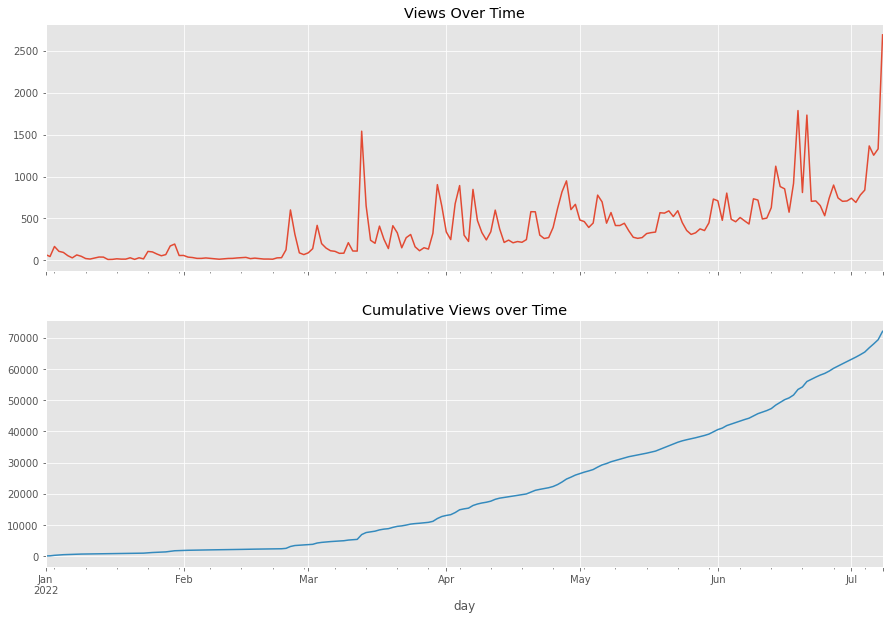

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
df.set_index("day")["views"].plot(ax=axs[0], title="Views Over Time", color=mypal[0])
df.set_index("day").cumsum()["views"].plot(
    ax=axs[1], title="Cumulative Views over Time", color=mypal[1]
)
plt.show()

## Subscribers Forecasting

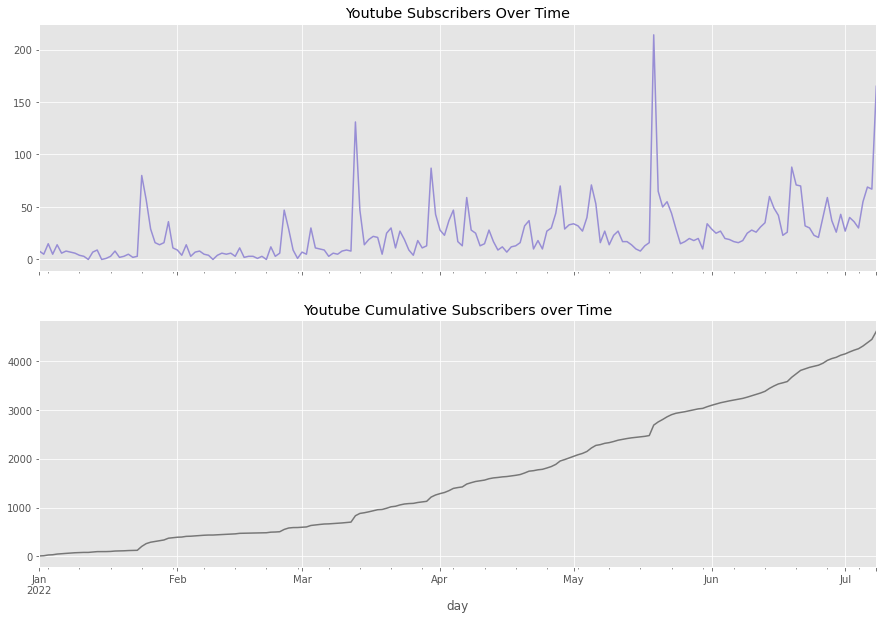

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
df.set_index("day")["subscribersGained"].plot(
    ax=axs[0], title="Youtube Subscribers Over Time", color=mypal[2]
)
df.set_index("day").cumsum()["subscribersGained"].plot(
    ax=axs[1], title="Youtube Cumulative Subscribers over Time", color=mypal[3]
)
plt.show()

# Watch Time

In [11]:
df["estimatedHoursWatched"] = df["estimatedMinutesWatched"] / 60

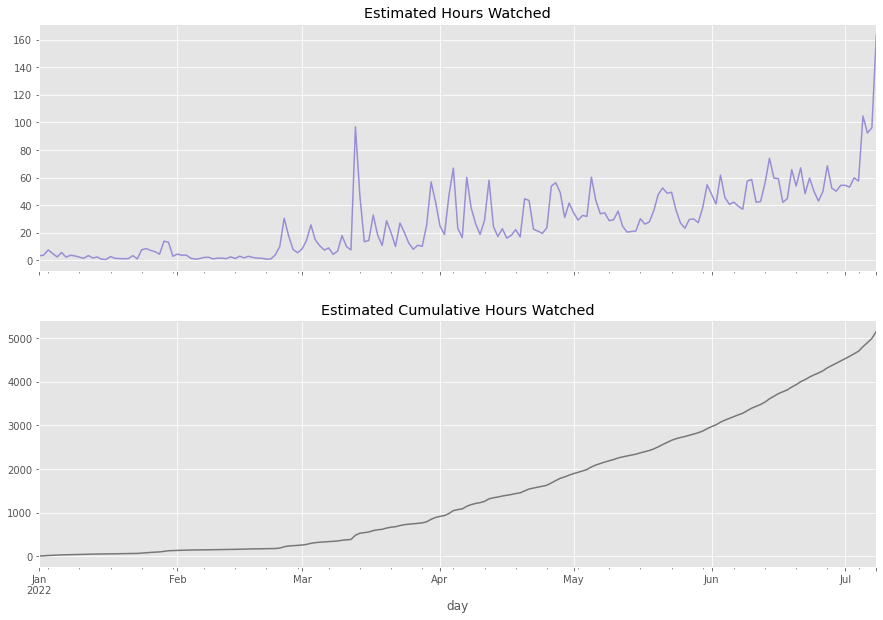

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
df.set_index("day")["estimatedHoursWatched"].plot(
    ax=axs[0], title="Estimated Hours Watched", color=mypal[2]
)
df.set_index("day").cumsum()["estimatedHoursWatched"].plot(
    ax=axs[1], title="Estimated Cumulative Hours Watched", color=mypal[3]
)
plt.show()

# Fit Linear Regression to Predict Subscribers

Coef: [23.65526938], Intercept -558.198496240602


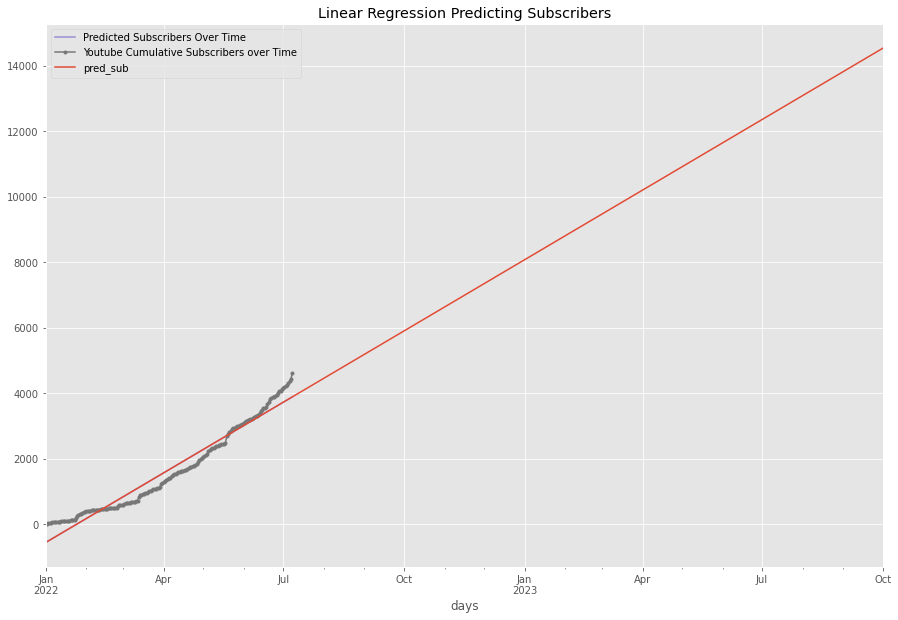

In [13]:
from sklearn.linear_model import LinearRegression

if "index" not in df.columns:
    df = df.reset_index()

lr = LinearRegression()

X = df[["index"]]
y = df["subscribersGained"].cumsum()

lr.fit(X, y)

# Make Predictions
df["pred_sub"] = lr.predict(df[["index"]])

pred_df = pd.DataFrame(pd.date_range("2022-01-01", "2023-10-01"), columns=["days"])
pred_df = pred_df.reset_index()
pred_df["pred_sub"] = lr.predict(pred_df[["index"]])

print(f"Coef: {lr.coef_}, Intercept {lr.intercept_}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True)
df.set_index("day")["pred_sub"].plot(
    ax=ax, label="Predicted Subscribers Over Time", color=mypal[2]
)
df.set_index("day").cumsum()["subscribersGained"].plot(
    ax=ax, label="Youtube Cumulative Subscribers over Time", color=mypal[3], style=".-"
)
pred_df.set_index("days")["pred_sub"].plot(ax=ax)
ax.set_title("Linear Regression Predicting Subscribers")
plt.legend()
plt.show()

In [14]:
pred_10k = pred_df.loc[pred_df["pred_sub"] > 10_000]["days"].dt.date.values[0]
print(f"Model predicts 10k Subscribers on {pred_10k}")

Model predicts 10k Subscribers on 2023-03-24


# Fit the Model on Only Recent Data
- Because the sub count has a recent trend

In [15]:
df["cumulativeSubs"] = df["subscribersGained"].cumsum()

Coef: [44.39285714], Intercept -3860.507142857142


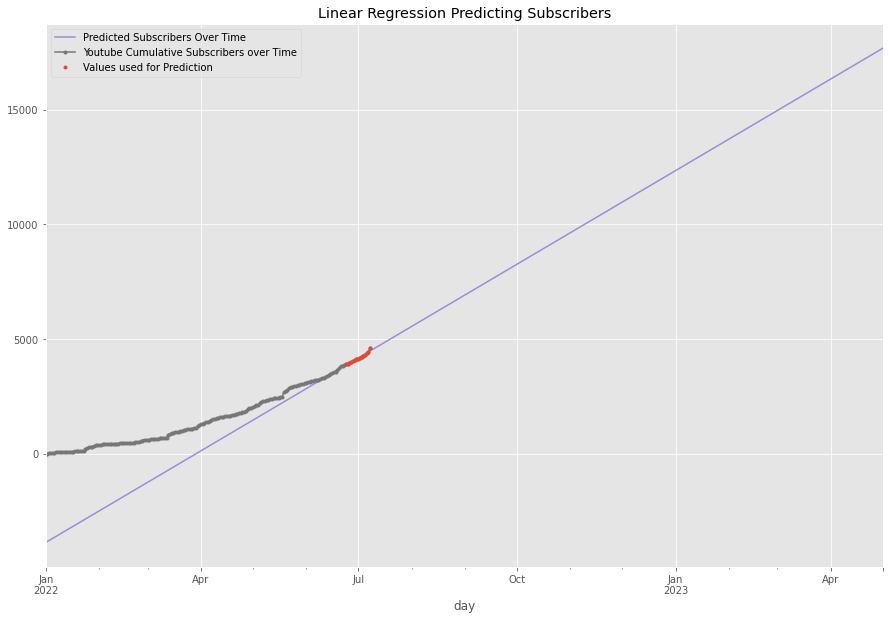

Model predicts 10k Subscribers on 2022-11-10


In [17]:
# Take the last 60 days of data to fit the model
df60 = df.tail(15)
lr = LinearRegression(fit_intercept=True)

X = df60[["index"]]
y = df60["cumulativeSubs"]

lr.fit(X, y)

# Make Predictions
df["pred_sub"] = lr.predict(df[["index"]])

pred_df = pd.DataFrame(pd.date_range("2022-01-01", "2023-05-01"), columns=["day"])
pred_df = pred_df.reset_index()
pred_df["pred_sub"] = lr.predict(pred_df[["index"]])

print(f"Coef: {lr.coef_}, Intercept {lr.intercept_}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True)
pred_df.set_index("day")["pred_sub"].plot(
    ax=ax, label="Predicted Subscribers Over Time", color=mypal[2]
)

df.set_index("day").cumsum()["subscribersGained"].plot(
    ax=ax, label="Youtube Cumulative Subscribers over Time", color=mypal[3], style=".-"
)
df60.set_index("day")["cumulativeSubs"].plot(
    ax=ax, label="Values used for Prediction", color=mypal[0], style="."
)
ax.set_title("Linear Regression Predicting Subscribers")
plt.legend()
plt.show()

pred_10k = pred_df.loc[pred_df["pred_sub"] > 10_000]["day"].dt.date.values[0]
print(f"Model predicts 10k Subscribers on {pred_10k}")

## Past 30 Days as Trend

In [ ]:
# Take the last 30 days of data to fit the model
df60 = df.tail(7)
lr = LinearRegression(fit_intercept=True)

X = df60[["index"]]
y = df60["cumulativeSubs"]

lr.fit(X, y)

# Make Predictions
df["pred_sub"] = lr.predict(df[["index"]])

pred_df = pd.DataFrame(pd.date_range("2022-01-01", "2023-09-01"), columns=["day"])
pred_df = pred_df.reset_index()
pred_df["pred_sub"] = lr.predict(pred_df[["index"]])

print(f"Coef: {lr.coef_}, Intercept {lr.intercept_}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True)
pred_df.set_index("day")["pred_sub"].plot(
    ax=ax, label="Predicted Subscribers Over Time", color=mypal[2]
)

df.set_index("day").cumsum()["subscribersGained"].plot(
    ax=ax, label="Youtube Cumulative Subscribers over Time", color=mypal[3], style=".-"
)
df60.set_index("day")["cumulativeSubs"].plot(
    ax=ax, label="Values used for Prediction", color=mypal[0], style="."
)
ax.set_title("Linear Regression Predicting Subscribers")

for x in [5_000, 10_000]:
    ax.axhline(x, color="grey", ls="--")
    if len(pred_df.query("pred_sub >= @x")["day"]) > 0:
        myday = pred_df.query("pred_sub >= @x")["day"].min()
        ax.axvline(myday, color="grey", ls="--")
ax.set_ylim(0, pred_df["pred_sub"].max())
plt.legend()
plt.show()

pred_10k = pred_df.loc[pred_df["pred_sub"] > 10_000]["day"].dt.date.values[0]
print(f"Model predicts 10k Subscribers on {pred_10k}")

# Predict Watch Hours over 4k

In [ ]:
df["cumulative_estimated_hours"] = df["estimatedMinutesWatched"].cumsum() / 60

In [ ]:
# Take the last 60 days of data to fit the model
df60 = df.tail(30)
lr = LinearRegression(fit_intercept=True)

X = df60[["index"]]
y = df60["cumulative_estimated_hours"]

lr.fit(X, y)

# Make Predictions
df["pred_watch_hours"] = lr.predict(df[["index"]])

pred_df = pd.DataFrame(pd.date_range("2022-01-01", "2023-05-01"), columns=["day"])
pred_df = pred_df.reset_index()
pred_df["pred_watch_hours"] = lr.predict(pred_df[["index"]])

print(f"Coef: {lr.coef_}, Intercept {lr.intercept_}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True)
pred_df.set_index("day")["pred_watch_hours"].plot(
    ax=ax, label="Predicted Watch Hours Over Time", color=mypal[2]
)

df.set_index("day")["cumulative_estimated_hours"].plot(
    ax=ax, label="Youtube Cumulative Watch Hours over Time", color=mypal[3], style=".-"
)
df60.set_index("day")["cumulative_estimated_hours"].plot(
    ax=ax, label="Values used for Prediction", color=mypal[0], style="."
)
ax.set_title("Linear Regression Predicting Watch Hours")
plt.legend()
plt.show()

pred_4k_watch = pred_df.loc[pred_df["pred_watch_hours"] > 4_000]["day"].dt.date.values[
    0
]
print(f"Model predicts 4k Watch Hours on {pred_4k_watch}")

# Pull Individual Video Data

## Part 1 Get the Videos Ids and Names

In [ ]:
SCOPES = ["https://www.googleapis.com/auth/yt-analytics.readonly"]


def get_youtube_service():
    API_SERVICE_NAME = "youtube"
    API_VERSION = "v3"
    CLIENT_SECRETS_FILE = "YOUR_CLIENT_SECRET_FILE.json"
    CLIENT_SECRETS_FILE = "client_secret_427323414311-3hsje8dbb8bsuu97c89k6c2jncgjvlae.apps.googleusercontent.com.json"

    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
    credentials = flow.run_console()
    return build(API_SERVICE_NAME, API_VERSION, credentials=credentials)

In [ ]:
youtube = get_youtube_service()

## Get the list of Videos and their names

In [ ]:
with open("youtube.key") as f:
    youTubeApiKey = f.read()
# youTubeApiKey = _ #Read here
youtube = build("youtube", "v3", developerKey=youTubeApiKey)

channel_id = "UCxladMszXan-jfgzyeIMyvw"
query = ""
res = (
    youtube.search()
    .list(
        q=query,
        part="id,snippet",
        channelId=channel_id,
        maxResults=50,
    )
    .execute()
)

myids = []
myvid_names = []
for x in res["items"]:
    if x["id"]["kind"] == "youtube#video":
        myids.append(x["id"]["videoId"])
        myvid_names.append(x["snippet"]["title"])

video_metadata = pd.DataFrame([myids, myvid_names]).T.rename(
    columns={0: "video_id", 1: "video_name"}
)
# To make video_id to video name
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()

## Part 2 - Pull Data for Each Video

In [ ]:
dfs = []
dfs2 = []
for video_id in video_metadata["video_id"]:
    request = youtubeAnalytics.reports().query(
        dimensions="day,insightTrafficSourceType",
        endDate="2022-11-01",
        ids="channel==MINE",
        metrics="views,estimatedMinutesWatched",
        sort="-day",
        startDate="2021-11-01",
        filters=f"video=={video_id}",
    )
    response = request.execute()
    source_df = out_to_df(response)
    if len(source_df) == 0:
        continue
    source_df2 = (
        source_df.set_index(["day", "insightTrafficSourceType"])["views"]
        .unstack()
        .fillna(0)
        .astype("int")
        .reset_index()
    )
    source_df2["video_id"] = video_id
    source_df2["day_since_release"] = (
        source_df2["day"].rank(ascending=True).astype("int")
    )

    source_df3 = (
        source_df.set_index(["day", "insightTrafficSourceType"])[
            "estimatedMinutesWatched"
        ]
        .unstack()
        .fillna(0)
        .astype("int")
        .reset_index()
    )
    source_df3["video_id"] = video_id
    source_df3["day_since_release"] = (
        source_df2["day"].rank(ascending=True).astype("int")
    )

    dfs.append(source_df2)
    dfs2.append(source_df3)

watch_stats = pd.concat(dfs2)
vid_stats = pd.concat(dfs)

In [ ]:
# Make "Other Column"
other_cols = (
    source_df2.drop(["video_id", "day"], axis=1).sum().sort_values().head(5).index
)

source_df2["OTHER(5)"] = source_df2[other_cols].sum(axis=1)
keep_cols = [c for c in source_df2.columns if c not in other_cols]

# Search Views only by Video

In [ ]:
vid_cumulative_search_views = (
    vid_stats.query("SHORTS.isna()")
    .set_index(["day", "video_id"])["YT_SEARCH"]
    .unstack()
    .fillna(0)
    .astype("int")
    .cumsum()
)
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()
vid_cumulative_search_views.columns = [
    " ".join(vid_name_map[c].split(" ")[:5])
    for c in vid_cumulative_search_views.columns
]

In [ ]:
vid_cumulative_search_views.plot(figsize=(15, 5))

In [ ]:
px.line(vid_cumulative_search_views, height=750)

# Plot by Since Release Date

In [ ]:
vid_stats.columns

In [ ]:
sources = [
    "END_SCREEN",
    "EXT_URL",
    "NOTIFICATION",
    "NO_LINK_OTHER",
    "PLAYLIST",
    "RELATED_VIDEO",
    "SUBSCRIBER",
    "YT_CHANNEL",
    "YT_OTHER_PAGE",
    "YT_PLAYLIST_PAGE",
    "YT_SEARCH",
    "ANNOTATION",
    "HASHTAGS",
    "SHORTS",
]

vid_stats[sources].sum().sort_values().plot(
    kind="barh", figsize=(10, 5), title="Views by Source"
)

In [ ]:
vid_days = {}
for vid, d in vid_stats.groupby("video_id"):
    vid_days[vid] = d["day_since_release"].max()

In [ ]:
SOURCE = "YT_SEARCH"

vid_views_release = (
    vid_stats.query("SHORTS.isna()")
    .set_index(["day_since_release", "video_id"])[SOURCE]
    .unstack()
    .fillna(0)
    .astype("int")
    .cumsum()
)

for vid, days in vid_days.items():
    vid_views_release.loc[vid_views_release.index > days, vid] = np.nan
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()
vid_views_release.columns = [
    " ".join(vid_name_map[c].split(" ")[:4]) for c in vid_views_release.columns
]

px.line(vid_views_release, title=SOURCE, height=750)

# Change In views over time

In [ ]:
px.line(
    vid_views_release.diff().rolling(7, center=True).mean(), title=SOURCE, height=750
)

# Views Post first Wave (after x days)

In [ ]:
SOURCE = "YT_SEARCH"

vid_views_release = (
    vid_stats.query("day_since_release >= 0")
    .set_index(["day_since_release", "video_id"])[SOURCE]
    # .sum(axis=1)
    .unstack()
    .fillna(0)
    .astype("int")
    .cumsum()
)

for vid, days in vid_days.items():
    vid_views_release.loc[vid_views_release.index > days, vid] = np.nan
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()
vid_views_release.columns = [
    " ".join(vid_name_map[c].split(" ")[:4]) for c in vid_views_release.columns
]

px.line(vid_views_release, title=SOURCE, height=750)

In [ ]:
color_pal = sns.color_palette()

In [ ]:
vid_stats.sum()

In [ ]:
SOURCE = "YT_SEARCH"
vid_views_release = (
    vid_stats.query("day_since_release >= 0")
    .set_index(["day_since_release", "video_id"])[SOURCE]
    # .sum(axis=1)
    .unstack()
    .fillna(0)
    .astype("int")
    .cumsum()
)

for vid, days in vid_days.items():
    vid_views_release.loc[vid_views_release.index > days, vid] = np.nan
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()
vid_views_release.columns = [
    " ".join(vid_name_map[c].split(" ")) for c in vid_views_release.columns
]

SOURCE = "NO_LINK_OTHER"

vid_views_release2 = (
    vid_stats.query("day_since_release >= 0")
    .set_index(["day_since_release", "video_id"])[SOURCE]
    # .sum(axis=1)
    .unstack()
    .fillna(0)
    .astype("int")
    .cumsum()
)


for vid, days in vid_days.items():
    vid_views_release2.loc[vid_views_release2.index > days, vid] = np.nan
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()
vid_views_release2.columns = [
    " ".join(vid_name_map[c].split(" ")) for c in vid_views_release2.columns
]

SOURCE = "SUBSCRIBER"

vid_views_release3 = (
    vid_stats.query("day_since_release >= 0")
    .set_index(["day_since_release", "video_id"])[SOURCE]
    # .sum(axis=1)
    .unstack()
    .fillna(0)
    .astype("int")
    .cumsum()
)

for vid, days in vid_days.items():
    vid_views_release3.loc[vid_views_release3.index > days, vid] = np.nan
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()
vid_views_release3.columns = [
    " ".join(vid_name_map[c].split(" ")) for c in vid_views_release3.columns
]


for c in vid_views_release.columns:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    vid_views_release[c].plot(figsize=(15, 3), ax=axs[0], title="Search")
    vid_views_release2[c].plot(ax=axs[1], color=color_pal[1], title="Other Link")
    vid_views_release3[c].plot(ax=axs[2], color=color_pal[2], title="Subscriber")
    fig.suptitle(c)
    plt.tight_layout()
    plt.show()

In [ ]:
search_counts = (
    vid_stats.set_index(["day_since_release", "video_id"])["YT_SEARCH"]
    .unstack()
    .fillna(0)
    .astype("int")
    .sum()
).sort_values()

search_counts = search_counts.to_frame("search_views")
search_counts["days_live"] = search_counts.index.map(vid_days)
search_counts["search_per_day"] = (
    search_counts["search_views"] / search_counts["days_live"]
)
search_counts.index = search_counts.index.map(vid_name_map)

In [ ]:
search_counts.index = search_counts.index.str.split(" ").str[:4].str.join(" ")

In [ ]:
color_pal = sns.color_palette()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
search_counts = search_counts.sort_values("search_per_day")
search_counts["search_views"].plot(
    kind="barh", ax=axs[0], color=color_pal[0], title="Search Views"
)
search_counts["days_live"].plot(
    kind="barh", ax=axs[1], color=color_pal[1], title="Days Live"
)
search_counts["search_per_day"].plot(
    kind="barh", ax=axs[2], color=color_pal[2], title="Search View Per Day"
)
plt.show()

# External URL

In [ ]:
vid_stats.columns

In [ ]:
for source in [
    "END_SCREEN",
    "EXT_URL",
    "HASHTAGS",
    "NOTIFICATION",
    "NO_LINK_OTHER",
    "PLAYLIST",
    "RELATED_VIDEO",
    "SUBSCRIBER",
    "YT_CHANNEL",
    "YT_OTHER_PAGE",
    "YT_PLAYLIST_PAGE",
    "YT_SEARCH",
    "ANNOTATION",
    "SHORTS",
]:
    counts = (
        vid_stats.set_index(["day_since_release", "video_id"])[source]
        .unstack()
        .fillna(0)
        .astype("int")
        .sum()
    ).sort_values()

    counts = counts.to_frame("search_views")
    counts["days_live"] = counts.index.map(vid_days)
    counts["search_per_day"] = counts["search_views"] / counts["days_live"]
    counts.index = counts.index.map(vid_name_map)
    counts.index = counts.index.str.split(" ").str[:4].str.join(" ")

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    counts = counts.sort_values("search_per_day")
    counts["search_views"].plot(
        kind="barh", ax=axs[0], color=color_pal[0], title=f"{source} Views"
    )
    counts["days_live"].plot(
        kind="barh", ax=axs[1], color=color_pal[1], title="Days Live"
    )
    counts["search_per_day"].plot(
        kind="barh", ax=axs[2], color=color_pal[2], title=f"{source} Views Per Day"
    )
    plt.show()

# Forcast Video Views

In [ ]:
vid_stats["total_views"] = vid_stats[sources].sum(axis=1)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
vid_stats.groupby("day")["total_views"].sum().plot(ax=axs[0])
vid_stats.groupby("day")["total_views"].sum().cumsum().plot(
    ax=axs[1], color=color_pal[2]
)

In [ ]:
all_dates = pd.date_range(
    vid_stats["day"].max() + pd.Timedelta("1d"),
    vid_stats["day"].max() + pd.Timedelta("365d"),
)

all_dates_df = pd.DataFrame(index=all_dates)
all_dates_df = all_dates_df.reset_index().rename(columns={"index": "day"})

total_views_df = (
    vid_stats.groupby("day")["total_views"].sum().sort_index().reset_index()
)
cum_sum_df = (
    vid_stats.groupby("day")["total_views"].sum().sort_index().cumsum().reset_index()
)

all_dates_df = all_dates_df.merge(total_views_df, on=["day"], how="outer")
all_dates_df = all_dates_df.merge(
    cum_sum_df.rename(columns={"total_views": "cumsum_views"}), on=["day"], how="outer"
)
all_dates_df = all_dates_df.sort_values("day").reset_index(drop=True)

all_dates_df["day_count"] = all_dates_df["day"].rank().astype("int")

X = (
    all_dates_df.query("cumsum_views > 10_000")
    .set_index("day_count")["cumsum_views"]
    .index
)
X = X.values.reshape(-1, 1)
y = (
    all_dates_df.query("cumsum_views > 10_000")
    .set_index("day_count")["cumsum_views"]
    .values
)

lr = LinearRegression()
lr.fit(X, y)
preds = lr.predict(all_dates_df["day_count"].values.reshape(-1, 1))
all_dates_df["pred"] = preds

# all_dates_df.to_csv("../032-shorts-tiktok/views.csv")

all_dates_df.loc[all_dates_df["pred"] < 0, "pred"] = 0
all_dates_df.set_index("day")[["cumsum_views", "pred"]].plot(figsize=(15, 5), ls="-")

In [ ]:
all_dates_df.query("pred >= 100_000")["day"].min()

# Change in Views Overall

In [ ]:
vid_stats.columns

In [ ]:
# SOURCE = "YT_SEARCH"

vid_views_release = (
    vid_stats.query("SHORTS.isna()")
    .set_index(["day_since_release", "video_id"])[sources]
    .sum(axis=1)
    .unstack()
    .fillna(0)
    .astype("int")
    .cumsum()
)

for vid, days in vid_days.items():
    vid_views_release.loc[vid_views_release.index > days, vid] = np.nan
vid_name_map = video_metadata.set_index("video_id")["video_name"].to_dict()
vid_views_release.columns = [
    " ".join(vid_name_map[c].split(" ")[:4]) for c in vid_views_release.columns
]

px.line(
    vid_views_release.diff().rolling(7, center=True).mean(), title="All", height=500
)